#Tasks at hand:-
## (1) Binary Label classification (Contains PCL (1) vs. No PCL (0))
## (2) Multilabel Classification (7 classes)

# File structure:-

## -->ANN RNN, LSTM's for both Multilabel and binary label classifications done in a sequential fashion.

## -->Run all lines files in a sequential fashion.

## -->Need to import 'dontpatronizeme_pcl.tsv' and 'dontpatronizeme_categories.tsv' to run this file.

#Binary label


In [ ]:
import os
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize, TreebankWordTokenizer, TweetTokenizer, MWETokenizer
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.metrics import multilabel_confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import defaultdict

In [ ]:

import tensorflow as tf
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
#from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
class DontPatronizeMe:

	def __init__(self, train_path, test_path):

		self.train_path = train_path
		self.test_path = test_path
		self.train_task1_df = None
		self.train_task2_df = None
		self.test_set_df = None

	def load_task1(self):
		"""
		Load task 1 training set and convert the tags into binary labels. 
		Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
		It returns a pandas dataframe with paragraphs and labels.
		"""
		rows=[]
		with open(os.path.join(self.train_path, 'dontpatronizeme_pcl.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]
				if l=='0' or l=='1':
					lbin=0
				else:
					lbin=1
				rows.append(
					{'par_id':par_id,
					'art_id':art_id,
					'keyword':keyword,
					'country':country,
					'text':t, 
					'label':lbin, 
					'orig_label':l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
		self.train_task1_df = df

	def load_task2(self, return_one_hot=True):
		# Reads the data for task 2 and present it as paragraphs with binarized labels (a list with seven positions, "activated or not (1 or 0)",
		# depending on wether the category is present in the paragraph).
		# It returns a pandas dataframe with paragraphs and list of binarized labels.
		tag2id = {
				'Unbalanced_power_relations':0,
				'Shallow_solution':1,
				'Presupposition':2,
				'Authority_voice':3,
				'Metaphors':4,
				'Compassion':5,
				'The_poorer_the_merrier':6
				}
		print('Map of label to numerical label:')
		print(tag2id)
		data = defaultdict(list)
		with open (os.path.join(self.train_path, 'dontpatronizeme_categories.tsv')) as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				text=line.split('\t')[2]#.lower()
				keyword=line.split('\t')[3]
				country=line.split('\t')[4]
				start=line.split('\t')[5]
				finish=line.split('\t')[6]
				text_span=line.split('\t')[7]
				label=line.strip().split('\t')[-2]
				num_annotators=line.strip().split('\t')[-1]
				labelid = tag2id[label]
				if not labelid in data[(par_id, art_id, text, keyword, country)]:
					data[(par_id,art_id, text, keyword, country)].append(labelid)

		par_ids=[]
		art_ids=[]
		pars=[]
		keywords=[]
		countries=[]
		labels=[]

		for par_id, art_id, par, kw, co in data.keys():
			par_ids.append(par_id)
			art_ids.append(art_id)
			pars.append(par)
			keywords.append(kw)
			countries.append(co)

		for label in data.values():
			labels.append(label)

		if return_one_hot:
			labels = MultiLabelBinarizer().fit_transform(labels)
		df = pd.DataFrame(list(zip(par_ids, 
									art_ids, 
									pars, 
									keywords,
									countries, 
									labels)), columns=['par_id',
														'art_id', 
														'text', 
														'keyword',
														'country', 
														'label',
														])
		self.train_task2_df = df


	def load_test(self):
		#self.test_df = [line.strip() for line in open(self.test_path)]
		rows=[]
		with open(self.test_path) as f:
			for line in f:
				t=line.strip().split('\t')
				rows.append(t)
		self.test_set_df = pd.DataFrame(rows, columns="par_id art_id keyword country text".split())

In [ ]:
dpm = DontPatronizeMe('.', '.')
dpm.load_task1()
dataframe= dpm.train_task1_df
dpm.load_task2()
dataframe_multi = dpm.train_task2_df

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
dataframe

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [ ]:
dataframe_multi

,par_id,art_id,text,keyword,country,label
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,@@7896098,Pope Francis washed and kissed the feet of Mus...,refugee,ng,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,@@17252299,Many refugees do n't want to be resettled anyw...,refugee,ng,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,@@3002894,"""Budding chefs , like """" Fred """" , """" Winston ...",in-need,ie,"[1, 0, 0, 1, 1, 1, 0]"
4,4089,@@25597822,"""In a 90-degree view of his constituency , one...",homeless,pk,"[1, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...
988,873,@@20374243,Citing the fact that these kids who died at Go...,poor-families,sg,"[1, 0, 0, 0, 1, 0, 0]"
989,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,"[1, 0, 0, 0, 0, 0, 0]"
990,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,"[1, 0, 0, 0, 0, 1, 0]"
991,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,"[1, 0, 0, 0, 0, 0, 0]"


##Preprocessing

In [ ]:
### utlity function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [ ]:
x= dataframe
x['p_text'] = x['text'].apply(preprocess) 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-5ad2756297cc>", line 2, in <module>
    x['p_text'] = x['text'].apply(preprocess)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/series.py", line 4357, in apply
    return SeriesApply(self, func, convert_dtype, args, kwargs).apply()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py", line 1043, in apply
    return self.apply_standard()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py", line 1101, in apply_standard
    convert=self.convert_dtype,
  File "pandas/_libs/lib.pyx", line 2859, in pandas._libs.lib.map_infer
  File "<ipython-input-7-04f893af85c2>", line 9, in preprocess
    doc = nlp(text)
  File "/usr/local/lib/python3.7/dist-packages/spacy/language.py", line 1026, in __call__
    doc = proc(doc, **component_cfg.g

KeyboardInterrupt: ignored

In [ ]:
dataframe

##Converting to tf dataset

In [ ]:
x = dataframe
x

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [ ]:
len(x)

10469

In [ ]:
tf_ds = tf.data.Dataset.from_tensor_slices((x['p_text'], x['label']))

for row in tf_ds.take(3):
  print(row)

KeyError: ignored

In [ ]:
tf_ds

NameError: ignored

In [ ]:
train_size = int(len(x)*0.8)

train_dataset = tf_ds.take(train_size)
test_dataset = tf_ds.skip(train_size)

In [ ]:
count = 0
for row in train_dataset.as_numpy_iterator():
#  print(row)
  count += 1
print(count)  

8375


In [ ]:
count = 0
for row in test_dataset.as_numpy_iterator():
#  print(row)
  count += 1
print(count)  

2094


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Mr Little say provide well quick treatment need'
 b'elderly citizen live poverty Hong Kong Oxfam say today report 2015 230,000 poor family people age 65 year number jump 14 percent compare 2011 Oxfam Hong Kong Poverty Report 2011 2015 find family 60 percent one- person household'
 b'24 year old Ottawa win World Cup medal race season include gold blondin lead overall standing woman World Cup mass start']

labels:  [0 0 0]


##Vectorization

In [ ]:
import numpy as np

In [ ]:
VOCAB_SIZE = 1000 #preset vocabulary size
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary()) #to get the first 20 vocabulary tokens
vocab[:20]

array(['', '[UNK]', 'say', 'people', 'immigrant', 'woman', 'need',
       'family', 'refugee', 'poor', 'year', 'vulnerable', 'child',
       'country', 'disabled', 'homeless', 'government', 'new', 'work',
       'help'], dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example[0]

array([167, 290,   2,  35, 127,   1, 470,   6,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [ ]:
for i in train_dataset.as_numpy_iterator():
  print(i)


Streaming output truncated to the last 5000 lines.
       b'poor family sing child read child play child child school nursery rhyme free family library book thing matter',
       b'fan America wake newspaper doorstep feature clue hint hopeless fountain kingdom 26;452;toolong',
       b'Opener Martin Guptill lift catch deep mid captain Kane Williamson edge second slip Neil Broom go ball catch fall lively Mohammad Shami big hit Colin de Grandhomme hopelessly strand pitch stump spinner Ravi Jadeja',
       b'grassroots concern group call government consider negative income tax poor family low- income family work allowance scheme benefit few family expect',
       b'Vanessa Mae Bondalian Rodel Filipino refugee live tiny subsidized apartment daughter Hong Kong idea young bespectacle American show doorstep night 2013 ask shelter wanted man world following < h > Lankans protect Edward Snowden',
       b'canadian government weaken federal legislation focus protect vulnerable plant animal',
   

## ANN

In [ ]:
import csv,sys
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vecto=TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=1000,
                           token_pattern=r'\b\w+\b')
tfidf = vecto.fit_transform(x['p_text'])
tfidf = tfidf.toarray()
terms=vecto.get_feature_names()
terms

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '000 people',
 '1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '200',
 '2010',
 '2011',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '3',
 '30',
 '300',
 '4',
 '40',
 '5',
 '50',
 '500',
 '6',
 '60',
 '7',
 '70',
 '8',
 '80',
 '9',
 'ability',
 'able',
 'abuse',
 'accept',
 'access',
 'accommodation',
 'accord',
 'account',
 'accuse',
 'achieve',
 'act',
 'action',
 'activist',
 'activity',
 'actually',
 'add',
 'addition',
 'address',
 'administration',
 'admit',
 'adult',
 'advocate',
 'affect',
 'afford',
 'afghan',
 'africa',
 'african',
 'age',
 'agency',
 'ago',
 'agree',
 'aid',
 'aim',
 'allow',
 'america',
 'american',
 'americans',
 'amp',
 'announce',
 'answer',
 'anti',
 'anti immigrant',
 'appear',
 'application',
 'apply',
 'approach',
 'area',
 'army',
 'arrest',
 'arrival',
 'arrive',
 'ask',
 'assault',
 'assist',
 'assistance',
 'association',
 'asylum',
 'asy

In [ ]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

from sklearn import metrics

X=tfidf
#X_test= tfidf[int(tfidf.shape[0]*0.8):]
y=dataframe ['label'] 

model = Sequential()
model.add(Dense(64,input_shape = (1000,), activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                64064     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 65,177
Trainable params: 65,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='bce',metrics=['accuracy',])
history=model.fit(X, y, epochs=20, batch_size=128, verbose=1,validation_split=0.2)

Epoch 1/20
66/66 [==============================] - 4s 27ms/step - loss: 0.3810 - accuracy: 0.9035 - val_loss: 0.2888 - val_accuracy: 0.9093
Epoch 2/20
66/66 [==============================] - 1s 13ms/step - loss: 0.2818 - accuracy: 0.9041 - val_loss: 0.2690 - val_accuracy: 0.9093
Epoch 3/20
66/66 [==============================] - 1s 14ms/step - loss: 0.2566 - accuracy: 0.9044 - val_loss: 0.2625 - val_accuracy: 0.9088
Epoch 4/20
66/66 [==============================] - 1s 12ms/step - loss: 0.2410 - accuracy: 0.9076 - val_loss: 0.2641 - val_accuracy: 0.9112
Epoch 5/20
66/66 [==============================] - 1s 10ms/step - loss: 0.2312 - accuracy: 0.9118 - val_loss: 0.2677 - val_accuracy: 0.9074
Epoch 6/20
66/66 [==============================] - 1s 11ms/step - loss: 0.2235 - accuracy: 0.9151 - val_loss: 0.2725 - val_accuracy: 0.9064
Epoch 7/20
66/66 [==============================] - 1s 9ms/step - loss: 0.2162 - accuracy: 0.9184 - val_loss: 0.2775 - val_accuracy: 0.9059
Epoch 8/20
66/

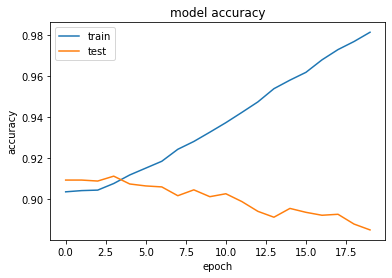

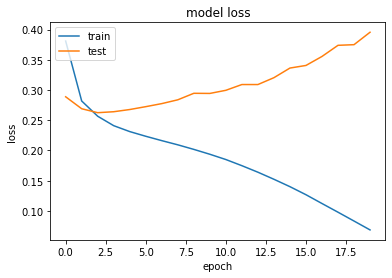

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

##Stacked_RNN

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
      
        
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=train_dataset,
                    validation_steps=30)

Epoch 1/10
131/131 [==============================] - 37s 204ms/step - loss: 0.5260 - accuracy: 0.9041 - val_loss: 0.3409 - val_accuracy: 0.9078
Epoch 2/10
131/131 [==============================] - 22s 169ms/step - loss: 0.3318 - accuracy: 0.9041 - val_loss: 0.3100 - val_accuracy: 0.9083
Epoch 3/10
131/131 [==============================] - 22s 168ms/step - loss: 0.3105 - accuracy: 0.9041 - val_loss: 0.3106 - val_accuracy: 0.9005
Epoch 4/10
131/131 [==============================] - 21s 160ms/step - loss: 0.2990 - accuracy: 0.9041 - val_loss: 0.2710 - val_accuracy: 0.9125
Epoch 5/10
131/131 [==============================] - 22s 167ms/step - loss: 0.2859 - accuracy: 0.9041 - val_loss: 0.2692 - val_accuracy: 0.9062
Epoch 6/10
131/131 [==============================] - 21s 160ms/step - loss: 0.2654 - accuracy: 0.9041 - val_loss: 0.2345 - val_accuracy: 0.9172
Epoch 7/10
131/131 [==============================] - 22s 169ms/step - loss: 0.2418 - accuracy: 0.9041 - val_loss: 0.2192 - val_ac

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

33/33 [==============================] - 1s 37ms/step - loss: 0.2760 - accuracy: 0.9112
Test Loss: 0.27603811025619507
Test Accuracy: 0.9111747741699219


(0.0, 0.5504419513046741)

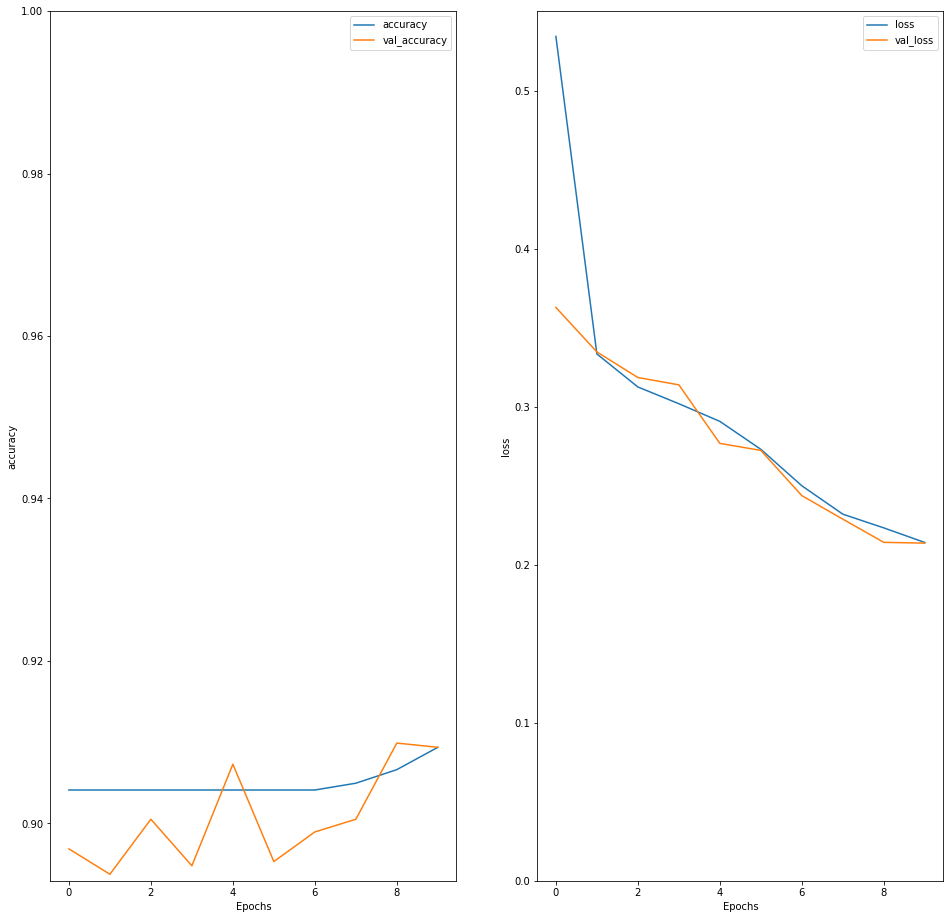

In [ ]:
plt.figure(figsize=(16,16))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

##Stacked LSTM

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,validation_split = 0.3,
                    validation_data=test_dataset,
                    validation_steps=20)

Epoch 1/10
131/131 [==============================] - 60s 327ms/step - loss: 0.5053 - accuracy: 0.9041 - val_loss: 0.3005 - val_accuracy: 0.9164
Epoch 2/10
131/131 [==============================] - 38s 291ms/step - loss: 0.3401 - accuracy: 0.9041 - val_loss: 0.2882 - val_accuracy: 0.9164
Epoch 3/10
131/131 [==============================] - 36s 275ms/step - loss: 0.3246 - accuracy: 0.9041 - val_loss: 0.2782 - val_accuracy: 0.9164
Epoch 4/10
131/131 [==============================] - 36s 279ms/step - loss: 0.3124 - accuracy: 0.9041 - val_loss: 0.2699 - val_accuracy: 0.9164
Epoch 5/10
131/131 [==============================] - 36s 272ms/step - loss: 0.2917 - accuracy: 0.9041 - val_loss: 0.2587 - val_accuracy: 0.9164
Epoch 6/10
131/131 [==============================] - 37s 285ms/step - loss: 0.2586 - accuracy: 0.9041 - val_loss: 0.2621 - val_accuracy: 0.9164
Epoch 7/10
131/131 [==============================] - 40s 305ms/step - loss: 0.2382 - accuracy: 0.9047 - val_loss: 0.2655 - val_ac

(0.0, 0.520068122446537)

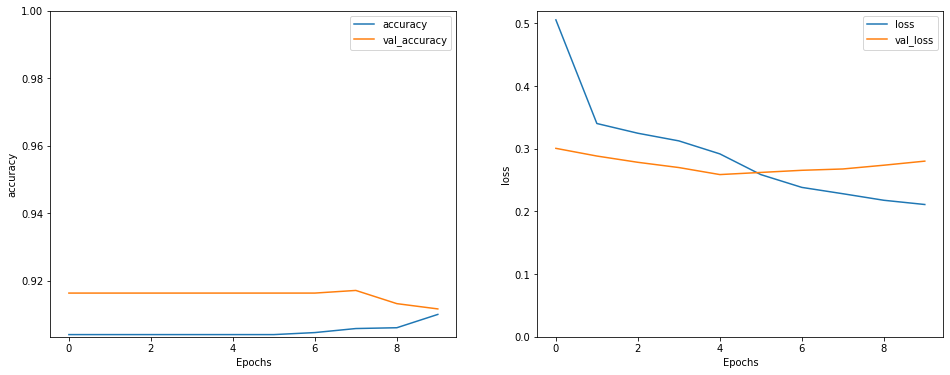

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('He needs to be hanged for his sins.') #example sentence
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 6s 6s/step


In [ ]:
predictions

array([[-3.0863993]], dtype=float32)

#Multilabel

##Preprocessing

In [ ]:
### utlity function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [ ]:
x= dataframe_multi #for multilabel data
x['p_text'] = x['text'].apply(preprocess) 

In [ ]:
def arr_to_lab(x, str,n):
    r = []
    for i in x['label']:
        r.append(i[n])
    r = pd.DataFrame(r) 
    x[str] = r[0]

In [ ]:
count = 0
for i in ['unb','sha','pre','aut','met','comp', 'ptm']:
  arr_to_lab(dataframe_multi,i,count)
  count += 1

In [ ]:
labels = dataframe_multi[['unb','sha','pre','aut','met','comp', 'ptm']]
labels

,unb,sha,pre,aut,met,comp,ptm
0,1,0,0,1,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,1,0,0,1,1,1,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
988,1,0,0,0,1,0,0
989,1,0,0,0,0,0,0
990,1,0,0,0,0,1,0
991,1,0,0,0,0,0,0


In [ ]:
X = []
sentences = list(dataframe_multi["p_text"])
for sen in sentences:
    X.append(sen)

y = labels.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


## ANN

In [ ]:
import csv,sys
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn import metrics

In [ ]:
vecto=TfidfVectorizer(stop_words='english',ngram_range=(1,3),max_features=500,
                           token_pattern=r'\b\w+\b')
tfidf = vecto.fit_transform(dataframe_multi['p_text'])
tfidf = tfidf.toarray()
terms=vecto.get_feature_names()
terms

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '1',
 '10',
 '2',
 '20',
 '2016',
 '25',
 '4',
 'able',
 'abuse',
 'access',
 'accord',
 'achieve',
 'act',
 'action',
 'add',
 'address',
 'administration',
 'affect',
 'africa',
 'african',
 'age',
 'ago',
 'aid',
 'aim',
 'allow',
 'america',
 'area',
 'ask',
 'assistance',
 'attention',
 'away',
 'bad',
 'bear',
 'beg',
 'begin',
 'believe',
 'benefit',
 'big',
 'blood',
 'border',
 'boy',
 'break',
 'bring',
 'build',
 'business',
 'buy',
 'camp',
 'care',
 'case',
 'catch',
 'cause',
 'celebrate',
 'center',
 'centre',
 'challenge',
 'chance',
 'change',
 'charity',
 'chief',
 'child',
 'child poor',
 'child poor family',
 'christmas',
 'church',
 'citizen',
 'city',
 'class',
 'close',
 'clothe',
 'cold',
 'college',
 'come',
 'come poor',
 'come poor family',
 'commitment',
 'community',
 'compassion',
 'condition',
 'consider',
 'continent',
 'continue',
 'contribution',
 'country',
 'create',
 'crisis',
 'cut',
 'cycle',
 'daily',
 'daughter',
 'day',
 'deal',
 'deat

In [ ]:
model = Sequential()
model.add(Dense(128,input_shape = (500,), activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(7,activation='sigmoid'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               64128     
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                                 
 dense_8 (Dense)             (None, 4)                 68        
                                                                 
 dense_9 (Dense)             (None, 7)                 35        
                                                                 
Total params: 66,295
Trainable params: 66,295
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy',])


In [ ]:
history=model.fit(tfidf, labels, epochs=30, batch_size=64, verbose=1,validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 1s 24ms/step - loss: 4.2478 - accuracy: 0.4899 - val_loss: 3.1265 - val_accuracy: 0.6935
Epoch 2/30
13/13 [==============================] - 0s 5ms/step - loss: 4.1555 - accuracy: 0.7254 - val_loss: 3.0225 - val_accuracy: 0.6935
Epoch 3/30
13/13 [==============================] - 0s 6ms/step - loss: 4.0753 - accuracy: 0.7280 - val_loss: 2.9341 - val_accuracy: 0.6935
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 4.0217 - accuracy: 0.7280 - val_loss: 2.8632 - val_accuracy: 0.6935
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 3.9964 - accuracy: 0.7280 - val_loss: 2.8141 - val_accuracy: 0.6935
Epoch 6/30
13/13 [==============================] - 0s 6ms/step - loss: 4.0074 - accuracy: 0.7280 - val_loss: 2.7896 - val_accuracy: 0.6935
Epoch 7/30
13/13 [==============================] - 0s 5ms/step - loss: 4.0543 - accuracy: 0.7280 - val_loss: 2.7920 - val_accuracy: 0.6935
Epoch 8/30
13/13 [=

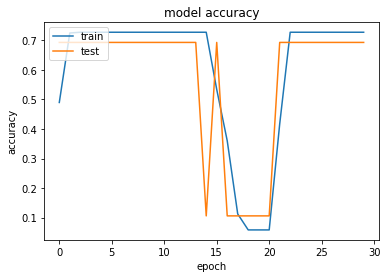

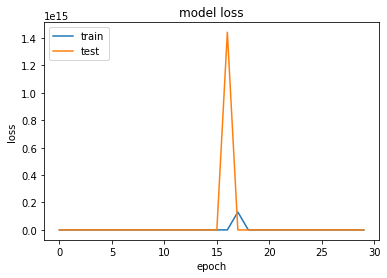

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

##Glove Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-11-15 19:35:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-15 19:35:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-15 19:35:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

##Stacked FFNN

In [ ]:
deep_inputs = Input(shape=(maxlen,)) 
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
Dense_Layer_1 = Dense(128,activation = 'relu')(embedding_layer)
Dense_Layer_2 = Dense(64,activation = 'relu')(Dense_Layer_1)
dense_layer_1 = Dense(7, activation='sigmoid')(Dense_Layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 200, 100)          540100    
                                                                 
 dense_28 (Dense)            (None, 200, 128)          12928     
                                                                 
 dense_29 (Dense)            (None, 200, 64)           8256      
                                                                 
 dense_30 (Dense)            (None, 200, 7)            455       
                                                                 
Total params: 561,739
Trainable params: 21,639
Non-trainable params: 540,100
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)


Epoch 1/5


ValueError: ignored

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

KeyError: ignored

##Stacked RNN

In [ ]:
from keras.layers import SimpleRNN

In [ ]:
deep_inputs = Input(shape=(maxlen,)) 
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
RNN_Layer_1 = SimpleRNN(128,return_sequences = True)(embedding_layer)
RNN_Layer_2 = SimpleRNN(64)(RNN_Layer_1)
dense_layer_1 = Dense(7, activation='sigmoid')(RNN_Layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          540100    
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 128)          29312     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 582,219
Trainable params: 42,119
Non-trainable params: 540,100
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
5/5 [==============================] - 9s 826ms/step - loss: 0.6701 - acc: 0.2362 - val_loss: 0.7704 - val_acc: 0.0566
Epoch 2/10
5/5 [==============================] - 3s 645ms/step - loss: 0.6867 - acc: 0.1213 - val_loss: 0.6126 - val_acc: 0.3019
Epoch 3/10
5/5 [==============================] - 3s 651ms/step - loss: 0.5675 - acc: 0.6457 - val_loss: 0.5289 - val_acc: 0.7484
Epoch 4/10
5/5 [==============================] - 3s 588ms/step - loss: 0.5230 - acc: 0.7260 - val_loss: 0.5013 - val_acc: 0.7484
Epoch 5/10
5/5 [==============================] - 2s 333ms/step - loss: 0.5078 - acc: 0.7260 - val_loss: 0.4951 - val_acc: 0.7484
Epoch 6/10
5/5 [==============================] - 2s 331ms/step - loss: 0.5031 - acc: 0.7260 - val_loss: 0.4975 - val_acc: 0.7484
Epoch 7/10
5/5 [==============================] - 2s 324ms/step - loss: 0.5027 - acc: 0.7260 - val_loss: 0.4981 - val_acc: 0.7484
Epoch 8/10
5/5 [==============================] - 2s 324ms/step - loss: 0.5012 - acc: 0.72

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

7/7 [==============================] - 0s 32ms/step - loss: 0.5211 - acc: 0.6834
Test Score: 0.5210596323013306
Test Accuracy: 0.6834170818328857


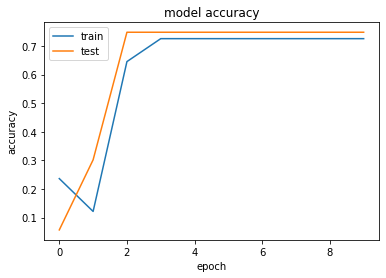

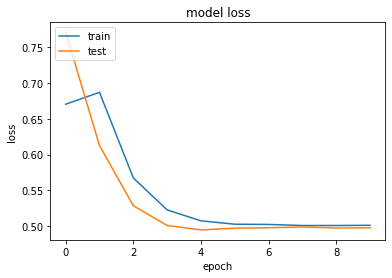

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Stacked LSTM

In [ ]:
#one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer 
#with 6 neurons since we have 6 labels in the output.
deep_inputs = Input(shape=(maxlen,)) 
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128,return_sequences = True)(embedding_layer)
LSTM_Layer_2 = LSTM(64)(LSTM_Layer_1)
dense_layer_1 = Dense(7, activation='sigmoid')(LSTM_Layer_2)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 100)          540100    
                                                                 
 lstm (LSTM)                 (None, 200, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 707,211
Trainable params: 167,111
Non-trainable params: 540,100
_________________________________________________________________
None


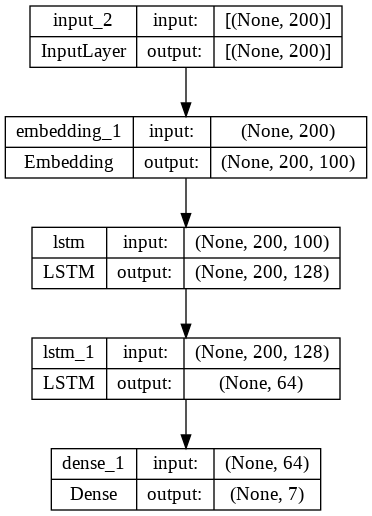

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
5/5 [==============================] - 13s 1s/step - loss: 0.6034 - acc: 0.7260 - val_loss: 0.5045 - val_acc: 0.7484
Epoch 2/10
5/5 [==============================] - 5s 1s/step - loss: 0.5122 - acc: 0.7260 - val_loss: 0.4965 - val_acc: 0.7484
Epoch 3/10
5/5 [==============================] - 7s 1s/step - loss: 0.5025 - acc: 0.7260 - val_loss: 0.5046 - val_acc: 0.7484
Epoch 4/10
5/5 [==============================] - 7s 1s/step - loss: 0.5036 - acc: 0.7260 - val_loss: 0.4992 - val_acc: 0.7484
Epoch 5/10
5/5 [==============================] - 5s 1s/step - loss: 0.5010 - acc: 0.7260 - val_loss: 0.4969 - val_acc: 0.7484
Epoch 6/10
5/5 [==============================] - 5s 1s/step - loss: 0.5024 - acc: 0.7244 - val_loss: 0.4962 - val_acc: 0.7484
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.5010 - acc: 0.7260 - val_loss: 0.4959 - val_acc: 0.7484
Epoch 8/10
5/5 [==============================] - 5s 1s/step - loss: 0.5002 - acc: 0.7260 - val_loss: 0.4968 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

7/7 [==============================] - 1s 118ms/step - loss: 0.5196 - acc: 0.6834
Test Score: 0.5195895433425903
Test Accuracy: 0.6834170818328857


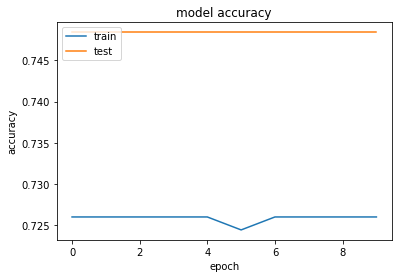

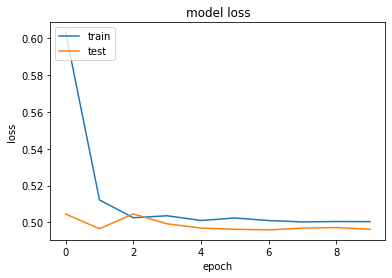

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Transformers

## Main imports and code

In [ ]:
# check which gpu we're using
!nvidia-smi

Wed Nov 16 09:53:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W /  70W |    336MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers
!pip install tensorboardx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 28.0 MB/s 
     |████████████████████████████████| 1.3 MB 47.1 MB/s 
     |████████████████████████████████| 7.6 MB 53.4 MB/s 
     |████████████████████████████████| 1.9 MB 54.1 MB/s 
     |████████████████████████████████| 451 kB 62.5 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 9.2 MB 44.1 MB/s 
     |████████████████████████████████| 5.5 MB 61.7 MB/s 
     |████████████████████████████████| 163 kB 64.9 MB/s 
     |████████████████████████████████| 168 kB 63.2 MB/s 
     |████████████████████████████████| 182 kB 65.3 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 166 kB 64.2 MB/s 
     |████████████████████████████████| 166 kB 62.8 MB/s 
     |████████████████████████████████| 162 kB 67.6 MB/s 
     |█████████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 21.4 MB/s 


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

## Load paragraph IDs

In [ ]:
trids = pd.read_csv('https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv')

In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [ ]:
data= dataframe

In [ ]:

data

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4




## Rebuild training set (Binary Label Classification)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })
  

In [ ]:
import random

In [ ]:
trdf1 = pd.DataFrame(rows)

## Rebuild test set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })
  

In [ ]:
len(rows)

2094

In [ ]:
tedf1 = pd.DataFrame(rows)

## RoBERTa Baseline for Task 1

In [ ]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [ ]:
training_set1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
2377,1775,refugee,Last but not the least element of culpability ...,0
2378,1776,refugee,"Then , taking the art of counter-intuitive non...",0
2379,1777,refugee,Kagunga village was reported to lack necessary...,0
2380,1778,vulnerable,"""After her parents high-profile divorce after ...",0


In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2382 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
Counter(preds_task1)

Counter({1: 460, 0: 1634})

In [ ]:
labels2file([[k] for k in preds_task1], 'task1.txt')

## Rebuild training set (Multilabel Classification)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf2 = pd.DataFrame(rows2)

In [ ]:
trdf2

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"
...,...,...,...
8370,8380,Rescue teams search for survivors on the rubbl...,"[0, 0, 0, 0, 0, 0, 0]"
8371,8381,The launch of ' Happy Birthday ' took place la...,"[0, 0, 0, 0, 0, 0, 0]"
8372,8382,"The unrest has left at least 20,000 people dea...","[0, 0, 0, 0, 0, 0, 0]"
8373,8383,You have to see it from my perspective . I may...,"[0, 0, 0, 0, 0, 0, 0]"


In [ ]:
trdf2.label = trdf2.label.apply(literal_eval)

## Rebuild test set (Multilabel Classification)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  rows2.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
tedf2 = pd.DataFrame(rows2)

In [ ]:
tedf2

,par_id,text,label
0,4046,We also know that they can benefit by receivin...,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,Pope Francis washed and kissed the feet of Mus...,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,Many refugees do n't want to be resettled anyw...,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...","[1, 0, 0, 1, 1, 1, 0]"
4,4089,"""In a 90-degree view of his constituency , one...","[1, 0, 0, 0, 0, 0, 0]"
...,...,...,...
2089,10462,"The sad spectacle , which occurred on Saturday...","[0, 0, 0, 0, 0, 0, 0]"
2090,10463,""""""" The Pakistani police came to our house and...","[0, 0, 0, 0, 0, 0, 0]"
2091,10464,"""When Marie O'Donoghue went looking for a spec...","[0, 0, 0, 0, 0, 0, 0]"
2092,10465,"""Sri Lankan norms and culture inhibit women fr...","[0, 0, 0, 0, 0, 0, 0]"


In [ ]:
tedf2.label = tedf2.label.apply(literal_eval)

## RoBERTa baseline for Task 2

In [ ]:

all_negs = trdf2[trdf2.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf2[trdf2.label.apply(lambda x:sum(x) > 0)]

training_set2 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])

In [ ]:
training_set2

,par_id,text,label
0,4341,"The scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,Durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,The next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,Far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,To strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"
...,...,...,...
1186,434,""""""" I was absolutely useless at school , hopel...","[0, 0, 0, 0, 0, 0, 0]"
1187,435,I also noticed the change in socio-economic le...,"[0, 0, 0, 0, 0, 0, 0]"
1188,436,"Can Donald Trump win ? It 's possible , but ce...","[0, 0, 0, 0, 0, 0, 0]"
1189,437,He added that any introduction of new law must...,"[0, 0, 0, 0, 0, 0, 0]"


In [ ]:
task2_model_args = MultiLabelClassificationArgs(num_train_epochs=1,
                                                no_save=True, 
                                                no_cache=True, 
                                                overwrite_output_dir=True
                                                )
task2_model = MultiLabelClassificationModel("roberta", 
                                            'roberta-base', 
                                            num_labels=7,
                                            args = task2_model_args, 
                                            use_cuda=cuda_available)
# train model
task2_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task2, _ = task2_model.predict(tedf2.text.tolist())

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'clas

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/1191 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
labels2file(preds_task2, 'task2.txt')

## Prepare submission

In [ ]:
!cat task1.txt | head -n 10

cat: task1.txt: No such file or directory


In [ ]:
!cat task2.txt | head -n 10

1,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
0,0,0,0,0,0,0
1,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
0,0,0,0,0,1,0


In [ ]:
!zip submission.zip task1.txt task2.txt

	zip warning: name not matched: task1.txt
  adding: task2.txt (deflated 97%)
